## Boundary Value Problems

Section 10.1

Here we study how to solve second order differential equations (systems of two first order differential equations), but instead of two initial conditions at $t_0$, we have "boundary" conditions at two different times. These can be constraints on $x(t)$ or $x'(t)$.

For example, a pedulum is governed by $\theta'' + \frac{g}{L}\sin\theta = 0$ where $\theta$ is the angle the pendulum makes with the vertical. 

Writing $x = \theta'$ the second equation becomes $x' + \frac{g}{L}\sin\theta = 0$. We can specify the angle at time $t_1$: $\theta(t_1)$ and the speed at time $t_2$: $x'(t_2)$.

We solve this system now. The ode and boundary condition functions differ from the form we used before: the derivatives are an argument to the functions, which are modified by the functions; they are not returned as the result of the function. In Julia, the convention is to add an ! to the function name if it modifies its arguments. This convention saves a memory allocation (creating a place to store the results of the calculation).

See example in the textbook and at https://docs.sciml.ai/DiffEqDocs/latest/tutorials/bvp_example/

In [1]:
using DifferentialEquations, Plots
using LaTeXStrings

In [2]:
function ode!(f, y, p, t)
    theta, x = y
    g, L = p
    f[1] = x  # theta' = x
    f[2] = -g/L*sin(theta) # x' = -g sin(theta) / L 
end;

In [3]:
# Here y is a vector of two functions which solve the ODE (Q 10.1.4, modified)
function bc!(g, y, p, t)
    g[1] = y(0)[2] - 0.0 # x(0) = 0.0
    g[2] = y(5)[1] - (pi/2) # theta(5) = pi/2
end;

In [4]:
domain = (0.0, 6.0) # find the solutio on this domain
est = [1, 0] # initial guess for solution, position = 1, velocity = 0; constant functions

2-element Vector{Int64}:
 1
 0

Use clever methods from the DifferentialEquations package to solve this equation.

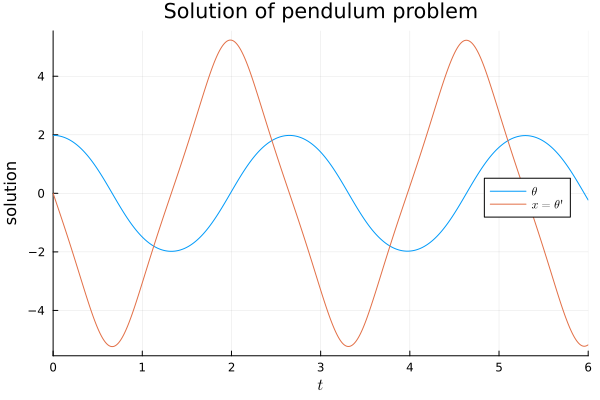

In [5]:
bvp = BVProblem(ode!, bc!, est, domain, [9.8, 1.0])
y = solve(bvp)
plot(y,label=[L"\theta" L"x = \theta'"],legend=:right,
    xlabel=L"t",ylabel="solution",
    title="Solution of pendulum problem")

In [6]:
y(0)

2-element Vector{Float64}:
 1.9808072245198018
 0.0

In [7]:
y(5)

2-element Vector{Float64}:
 1.5707963329922228
 2.768166432155093

In [17]:
pi/2

1.5707963267948966

A different solution can be found using a different initial guess at the solution.

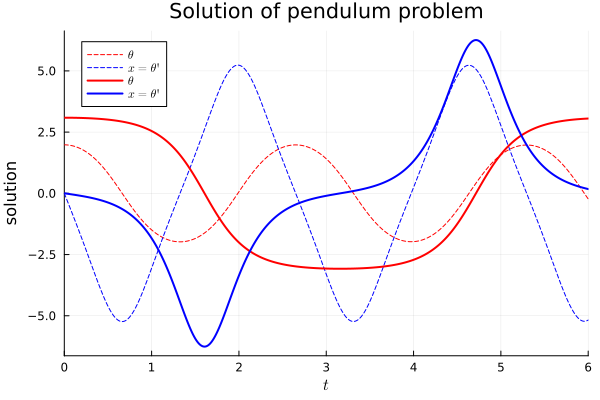

In [8]:
est = [3, 0] # initial guess for solution, position = 1, velocity = 0; constant functions
bvp = BVProblem(ode!, bc!, est, domain, [9.8, 1.0])
y2 = solve(bvp)
plot(y, label=[L"\theta" L"x = \theta'"], linestyle = :dash, linecolor = [:red :blue])
plot!(y2,label=[L"\theta" L"x = \theta'"],legend=:topleft,
    xlabel=L"t",ylabel="solution",
    title="Solution of pendulum problem", linewidth = 2,
    linecolor = [:red :blue])

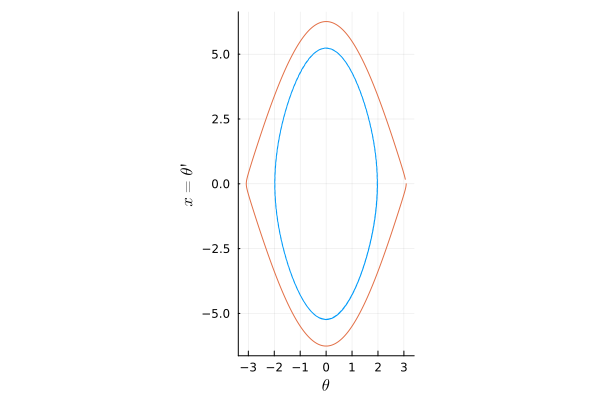

In [9]:
plot(y, idxs=(1,2), aspect_ratbio = 1, linestyle = :dash)
plot!(y2, idxs=(1,2), aspect_ratio = 1, legend = :none, xlabel = L"\theta", ylabel = L"x = \theta'")

In [10]:
y2(0.0)

2-element Vector{Float64}:
 3.0884890832764307
 0.0019110674499856477

## Solving the problem using shooting

Section 10.2

Here is one way to solve this problem: Solve an IVP and vary the unspecified initial condition until the desired value at the second time is achieved.

Here we solve the pendulum IVP with $\theta'(0) =0$ and various values of $\theta(0)$. We will plot $\theta(t)$ and look for an initial condition that has $\theta(5) = \pi/2$.

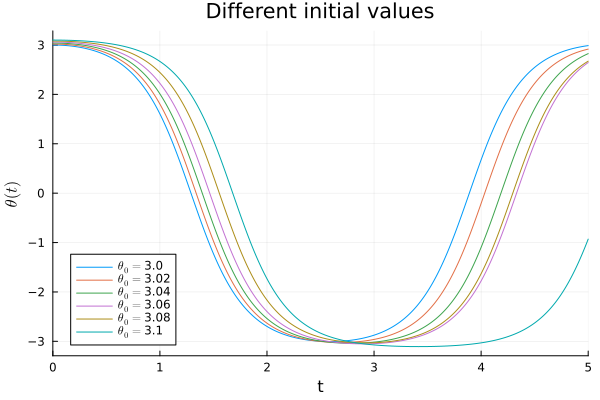

In [20]:
f = (y, p, t) -> [ y[2]; -p[1]/p[2]*sin(y[1]) ]
t_range = (0.0,5.0);
plt = plot(xaxis=(L"t"), yaxis=(L"\theta(t)"),   
    title="Different initial values", legend = :bottomleft)

for theta0 in 3.0:0.02:3.1 #  1.95:0.02:2.02 # 3.0:0.02:3.1
    IVP = ODEProblem(f, [theta0, 0.0], t_range, [9.8, 1.0])
    y = solve(IVP, Tsit5())
    plot!(y, idxs=[1], label=L"\theta_0 = " * "$theta0")
end
plt

In [12]:
pi/2

1.5707963267948966

Now, incorporate a root funding function into the process to determine the correct initial condition numerically.

In [13]:
include("fnc.jl")
using LinearAlgebra
"""
    shoot(ϕ,xspan,g₁,g₂,init)

Shooting method to solve a two-point boundary value problem with
ODE u'' = `ϕ`(x,u,u') for x in `xspan`, left boundary condition 
`g₁`(u,u')=0, and right boundary condition `g₂`(u,u')=0. The
value `init` is an initial estimate for vector [u,u'] at x=a.

Returns vectors for the nodes, the solution u, and derivative u'.
"""
function shoot(ϕ,xspan,g₁,g₂,init,tol=1e-5)
    # ODE posed as a first-order equation in 2 variables.
    shootivp = (v,p,x) -> [ v[2]; ϕ(x,v[1],v[2]) ]

    # Evaluate the difference between computed and target values at x=b.
    function objective(s)
        IVP = ODEProblem(shootivp,s,float.(xspan))
        sol = solve(IVP,Tsit5(),abstol=tol/10,reltol=tol/10)
        x = sol.t;  y = sol;
        return [g₁(s...),g₂(y[end]...)]
    end

    # Find the unknown quantity at x=a by rootfinding.
    x = [];  y = [];   # these values will be overwritten
    s = levenberg(objective,init,xtol=tol)[:,end]

    # Use the stored last solution of the IVP. 
    u,du_dx = eachrow(y) 
    return x,u,du_dx,s
end

shoot

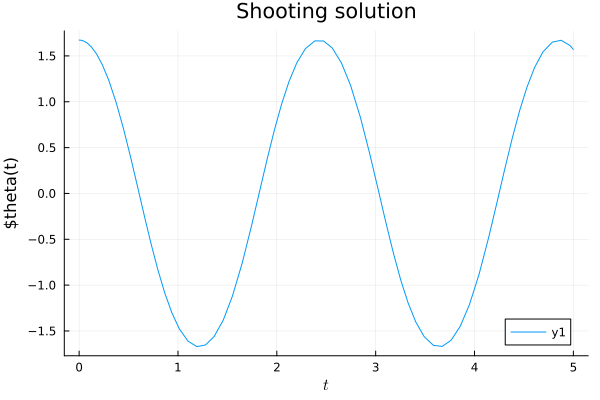

In [14]:
ϕ = (t, θ, dθdt) -> -9.8/1.0*sin(θ); 
g₁(θ, dθ) = dθ-0.0     # θ' = 0 at left
g₂(θ, dθ) = θ-pi/2    # θ = pi/2 at right
t_span = (0.0, 5.0)

t, θ, dθdt, s = shoot(ϕ, t_span, g₁, g₂, [1.0, 0.5])
plot(t,θ,title="Shooting solution",
    xaxis=(L"t"), yaxis=(L"$theta(t)"))

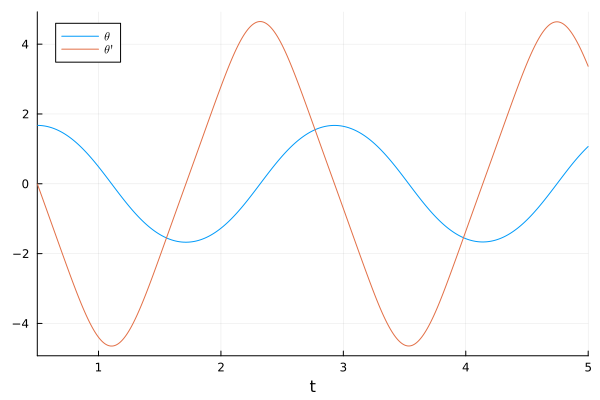

In [16]:
IVP = ODEProblem(f, s[end], t_range, [9.8, 1.0])
y = solve(IVP, Tsit5())
plot(y, idxs=[1], label=L"\theta")
plot!(y, idxs=[2], label=L"\theta'")

Two problems with this method:

* With oscillating solutions like we have for the pendulum, there can be many possible solutions,
* The error in the IVP grows exponentially with $t$; to get the solution accurately on the right endpoint may require very small time steps or high precision on the left endpoint.

A better approach is 'collocation' using Chebyshev points; see the next two sections.